# Option Pricing: Black-Scholes, Heston, and Merton
## Overall Objective: Understand and compare three fundamental option pricing models.

<span style="color:gray; opacity: 0.5;">**1. Black-Scholes:** The benchmark model assuming constant volatility.</span>  
    <span style="color:gray; opacity: 0.5;">_Provides a great baseline and is computationally efficient, but assumes constant $\sigma$ which is unrealistic for modern markets._</span>

<div style="border-left: 4px solid #2196F3; padding-left: 15px;">

**2. Merton Jump: Adds "jumps" to the asset price to model market shocks.**   
_Captures "Fat Tails" and sudden crashes via Poisson jumps._
</div>

<span style="color:gray; opacity: 0.5;">**3. Heston:** Adds stochastic volatility (volatility clustering and mean reversion).</span>  
    <span style="color:gray; opacity: 0.5;">_Captures the "Smirk" or "Skew" via stochastic vol—essential for pricing OTM puts accurately._</span>


## 2. Merton Jump Diffusion (MJD)

Markets sometimes crash. Black-Scholes and Heston (mostly) assume continuous paths. Merton adds a "Jump" component.

### The Dynamics (SDE)

$$dS_t = (\mu - \lambda k) S_t dt + \sigma S_t dW_t + S_t (Y - 1) dN_t$$

Where:

- $dN_t$: Poisson process (Jump counter) with intensity $\lambda$ (avg jumps per year).
    
- $Y$: Jump size, log-normally distributed $\ln(Y) \sim N(\mu_J, \delta^2)$.
    
- $k$: Expected jump size $E[Y-1] = e^{\mu_J + \delta^2/2} - 1$.
    

### Simulation Approach

While closed-form solutions exist (infinite series of BS prices), Monte Carlo is excellent for intuition here to _see_ the jumps.

## Imports and Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
from scipy.integrate import quad
import seaborn as sns

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Global Parameters (Toggles)
S0 = 100.0    # Spot Price
K_list = np.linspace(80, 120, 50) # Range of Strikes for plotting
T = 1.0       # Time to Maturity (1 year)
r = 0.05      # Risk-free rate
q = 0.0       # Dividend yield

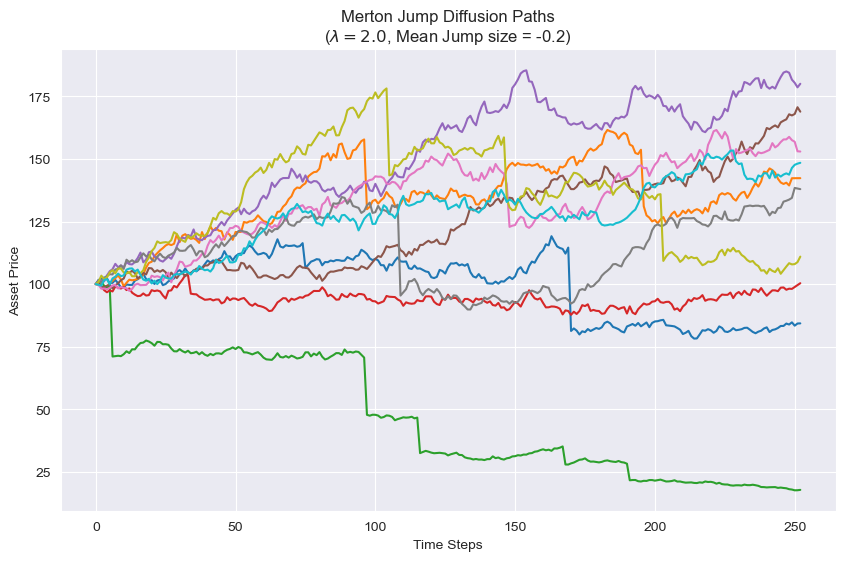

In [4]:
def merton_jump_paths(S0, T, r, sigma, lam, mu_j, delta, n_steps=252, n_paths=10):
    """
    Simulates paths for Merton Jump Diffusion.
    """
    dt = T / n_steps
    
    # 1. Brownian Motion part (Standard BS)
    # Z ~ N(0, 1)
    Z = np.random.normal(0, 1, size=(n_steps, n_paths))
    
    # 2. Poisson Jump part
    # J ~ Poisson(lam * dt) -> Number of jumps in this step
    J = np.random.poisson(lam * dt, size=(n_steps, n_paths))
    
    # 3. Jump Magnitude
    # If J=1, we add a normal shock N(mu_j, delta)
    # We sum up shocks if multiple jumps occur in one dt (rare but possible)
    mean_jump = np.exp(mu_j + 0.5 * delta**2) - 1
    drift_correction = lam * mean_jump
    
    # Create path array
    S = np.zeros((n_steps + 1, n_paths))
    S[0] = S0
    
    for t in range(1, n_steps + 1):
        # Continuous return
        continuous_log_ret = (r - drift_correction - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1]
        
        # Jump return
        # Calculate sum of log-normal jumps for this step
        # Jump size Y is log-normal, so log(Y) is normal
        jump_log_ret = np.random.normal(mu_j, delta, size=(n_paths)) * J[t-1]
        
        S[t] = S[t-1] * np.exp(continuous_log_ret + jump_log_ret)
        
    return S

# Parameters for Jumps
lam = 2.0      # Expect 2 jumps per year
mu_j = -0.2    # Average jump is -20% (Downside shock)
delta = 0.1    # Volatility of the jump size
sigma_m = 0.2  # Diffusion volatility

paths = merton_jump_paths(S0, T, r, sigma_m, lam, mu_j, delta, n_paths=10)

plt.figure(figsize=(10, 6))
plt.plot(paths)
plt.title(f"Merton Jump Diffusion Paths\n($\lambda={lam}$, Mean Jump size = {mu_j})")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.show()